In [933]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf
from scipy import signal


In [818]:
# Шаг 1. Загрузка данных и предобработка
file_path = '/Users/danilalipatov/Downloads/resemple_data_cat-last.xlsx'
df = pd.read_excel(file_path)
df["identifier"] = df["identifier"].astype(str)
df.columns

Index(['Unnamed: 0', 'identifier', 'agency', '_ro_type', 'resampled_dates',
       'resampled_values', 'rating_category'],
      dtype='object')

In [1129]:
df["resampled_dates"] = pd.to_datetime(df["resampled_dates"])
df_result = df.dropna(subset=["identifier", "resampled_values", "resampled_dates", "agency", "_ro_type"])
# df_result = df_result[(df_result["agency"] == "Expert RA") & (df_result["_ro_type"] == "CBNK - кредитная организация")]
df_result = df_result[(df_result["agency"] == "Expert RA")]
df_result = df_result[df_result["resampled_dates"].dt.year >= 2015]
df_result["resampled_values"] = df_result["resampled_values"].astype(int)
df_result = df_result.groupby("identifier").filter(lambda x: x["resampled_values"].dropna().nunique() > 2)

# Убираем компании, у которых непустых значений меньше порога
threshold = 1  # Например, минимум 10 непустых наблюдений
df_result = df_result.groupby("identifier").filter(lambda x: x["resampled_values"].count() >= threshold)


In [1131]:
df_result["identifier"].unique()

array(['7713011336', '7727051787', '6623029538', '5244009279',
       '4401116480', '7707050464', '7701045732', '7835905108',
       '5260059340', '7719780320', '1326024785', '7725520440',
       '7709129705', '3906098008', '7831000027', '7706548313',
       '7729399756', '7804493447', '7705522866', '7750004009',
       '2465029704', '7707492166', '6829000028', '7838408320',
       '4214005204', '1650014919', '2225019491', '7805233787',
       '1657023630', '5250042549', '7702045051', '1435126628',
       '106000547', '1326021671', '1435138944', '7704216908',
       '7705513090', '5402155821', '7716695349', '2310050140',
       '3317000799', '7451032223', '7725497022', '7706196340',
       '7704612010', '7704627560', '7705512995', '5610000466',
       '7714312079', '7725038124', '7704082517', '7453297458',
       '1435159327', '7707067683', '5407249872', '7712034098',
       '7744000912', '7728306068', '7727480641', '8601023568',
       '7703213534', '7705634425', '1101300820', '774400

In [1133]:
len(df_result["identifier"].unique())

73

In [1135]:
# === Шаг 1. Подготовка данных ===
df_agg = df_result  # Данные уже агрегированы по месяцам

# === Шаг 2. Формирование сводной таблицы (pivot) ===
pivot_df = df_agg.pivot(index="resampled_dates", columns="identifier", values="resampled_values")
# pivot_df = pivot_df.loc[:, pivot_df.count() > 5] 

In [1138]:
print(pivot_df)

identifier       106000547  1101300820  1326021671  1326024785  1435126628  \
resampled_dates                                                              
2015-01-31             NaN         NaN         NaN         NaN         NaN   
2015-02-28             NaN         NaN         NaN         NaN         NaN   
2015-03-31             NaN         NaN         NaN         NaN         NaN   
2015-04-30             NaN         NaN         NaN         NaN         NaN   
2015-05-31             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
2024-07-31             4.0         5.0         7.0         5.0         7.0   
2024-08-31             4.0         5.0         7.0         5.0         7.0   
2024-09-30             4.0         5.0         7.0         5.0         7.0   
2024-10-31             4.0         5.0         7.0         5.0         7.0   
2024-11-30             5.0         6.0         7.0         5.0  

In [1140]:
total_nan = pivot_df.isna().sum().sum()
print(f"Общее количество NaN: {total_nan}")
# pivot_df = pivot_df.loc[:, pivot_df.nunique(dropna=True) > 1]

Общее количество NaN: 2190


In [1142]:
correlation = pivot_df["106000547"].corr(pivot_df["1101300820"])
print(f"Корреляция между 106000547 и 1101300820: {correlation:.4f}")
print(pivot_df["106000547"].unique(), pivot_df["1101300820"].unique())

Корреляция между 106000547 и 1101300820: 0.2990
[nan  3.  4.  5.] [nan  4.  5.  6.]


In [1144]:
# Проверяем количество ненулевых значений
print(pivot_df[["106000547", "1101300820"]].count())

# Проверяем дисперсию
print(pivot_df[["106000547", "1101300820"]].var())
df_corr = pivot_df[["106000547", "1101300820"]].dropna(how="any")
correlation = df_corr["106000547"].corr(df_corr["1101300820"], method="spearman")
print(f"Корреляция между 106000547 и 1101300820: {correlation:.4f}")
print(pivot_df["106000547"].dropna().unique(), pivot_df["1101300820"].dropna().unique())

identifier
106000547     94
1101300820    82
dtype: int64
identifier
106000547     0.109014
1101300820    0.256098
dtype: float64
Корреляция между 106000547 и 1101300820: 0.2255
[3. 4. 5.] [4. 5. 6.]


In [1146]:
len(pivot_df.columns) * len(pivot_df)

8687

In [1148]:
pivot_df.dtypes
print(pivot_df.notna().sum())
print(pivot_df.var())
print(pivot_df.nunique())

identifier
106000547     94
1101300820    82
1326021671    94
1326024785    96
1435126628    94
              ..
7835905108    96
7838408320    95
8601023568    87
8601027509    80
9718077239    36
Length: 73, dtype: int64
identifier
106000547     0.109014
1101300820    0.256098
1326021671    1.372684
1326024785    0.546382
1435126628    1.327499
                ...   
7835905108    0.587719
7838408320    1.079059
8601023568    0.557605
8601027509    0.458070
9718077239    0.650000
Length: 73, dtype: float64
identifier
106000547     3
1101300820    3
1326021671    3
1326024785    3
1435126628    4
             ..
7835905108    3
7838408320    3
8601023568    4
8601027509    3
9718077239    3
Length: 73, dtype: int64


Cross-Correlation Matrix (Pearson) between Companies (INN):
identifier  106000547  1101300820  1326021671  1326024785  1435126628  \
identifier                                                              
106000547    1.000000    0.225540    0.415638    0.598519    0.756819   
1435138944   0.289725   -0.371988   -0.238993    0.030192    0.228826   
4214005204  -0.384454   -0.358957   -0.423229   -0.423164   -0.348613   
5244009279  -0.376924   -0.874967   -0.815856   -0.760863   -0.470338   
5407249872   0.248333    0.669702    0.849058    0.577820    0.332209   
7702045051  -0.287375   -0.528658   -0.729674   -0.548291   -0.536824   
7704082517  -0.257631   -0.595603   -0.746916   -0.510908   -0.300495   
7704612010   0.225256    0.596666    0.773655    0.529198    0.311252   
7704627560   0.415961    0.705478    0.852517    0.772489    0.588032   
7705512995   0.296792    0.753364    0.871653    0.651262    0.383045   
7705513090   0.469440    0.410863    0.511202    0.482240    0.4

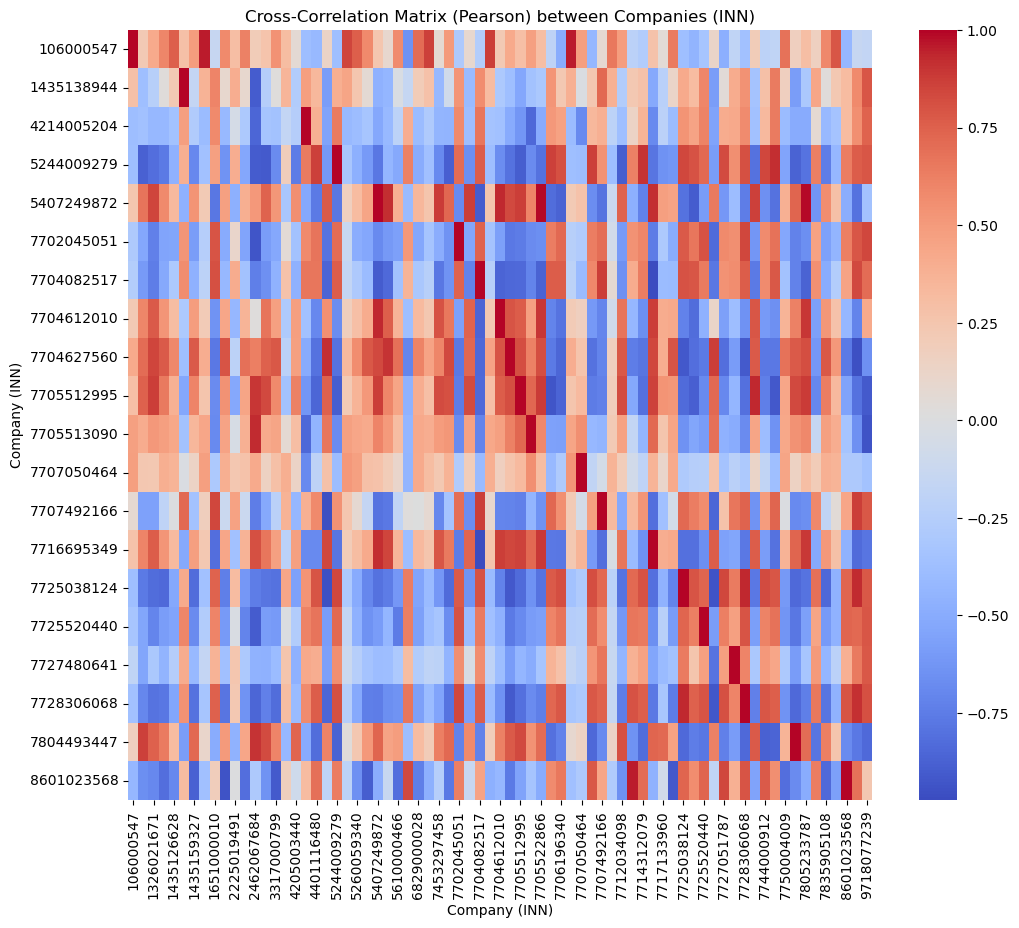

20 73


In [1150]:
# === Шаг 3. Вычисление кросс-корреляционной матрицы ===
cross_corr_matrix = pivot_df.corr(method="spearman")  # Можно заменить на 'spearman' или 'kendall', 'pearson'
cross_corr_matrix = cross_corr_matrix.dropna(axis=0)  # Удалить строки, где все значения NaN
cross_corr_matrix = cross_corr_matrix.dropna(axis=1)  # Удалить столбцы, где все значения NaN
# === Шаг 4. Вывод результатов ===
print("Cross-Correlation Matrix (Pearson) between Companies (INN):")
print(cross_corr_matrix)

# === Шаг 5. Визуализация через тепловую карту ===
plt.figure(figsize=(12, 10))
sns.heatmap(cross_corr_matrix, cmap="coolwarm")
plt.title("Cross-Correlation Matrix (Pearson) between Companies (INN)")
plt.xlabel("Company (INN)")
plt.ylabel("Company (INN)")
plt.show()
print(len(cross_corr_matrix.index), len(cross_corr_matrix.columns))

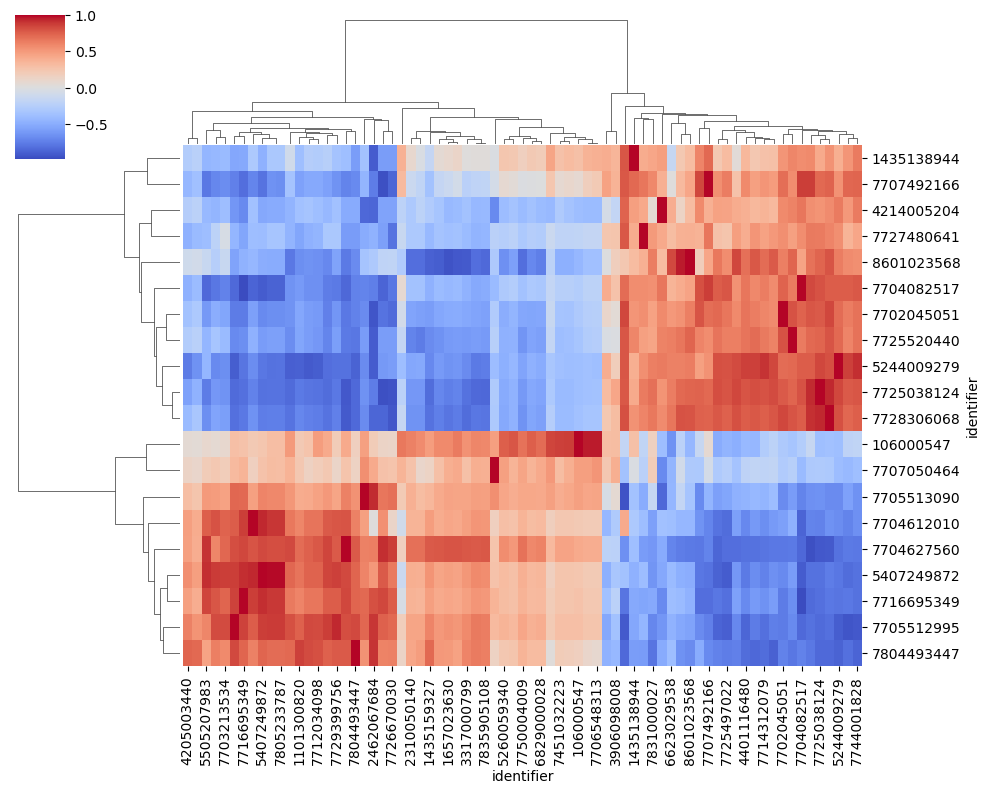

In [1151]:
sns.clustermap(cross_corr_matrix.fillna(0), cmap='coolwarm', figsize=(10, 8))
plt.show()

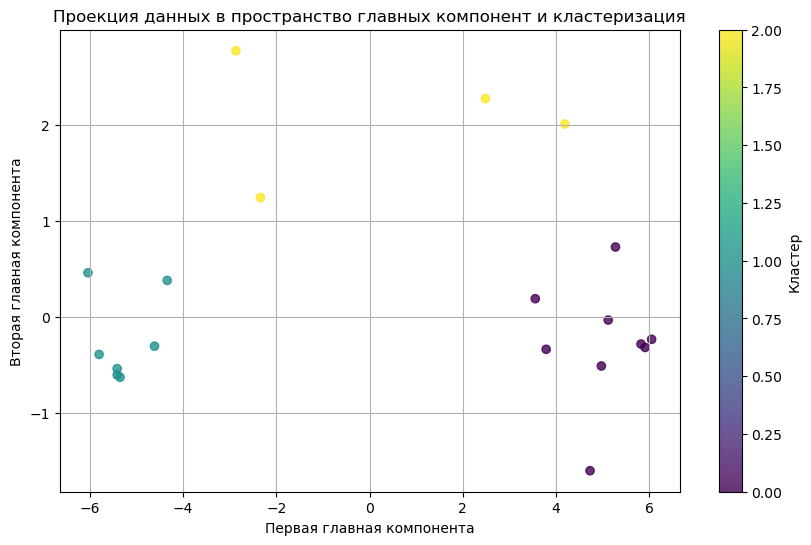

Топ-5 компаний по вкладу в главные компоненты: ['5260059340', '1650014919', '1435138944', '7706548313', '7707492166']
Топ-5 плохих компаний по вкладу в главные компоненты: ['4214005204', '7744000912', '7713011336', '7714312079', '4401116480']


In [1152]:
# Применяем SVD для выделения главных компонент
n_components = 2  # Берем две главные компоненты
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(cross_corr_matrix.fillna(0))

# Оцениваем, какие компании сильнее всего связаны с главными компонентами
components = svd.components_
importance = np.abs(components).sum(axis=0)
top_companies = cross_corr_matrix.columns[np.argsort(importance)[-5:]]  # Топ-5 компаний по вкладу
bad_companies = cross_corr_matrix.columns[np.argsort(importance)[:5]]  # Топ-5 bad компнаний по вкладу
# Нормализация перед кластеризацией
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Кластеризация с помощью KMeans
n_clusters = 3  # Можно подобрать оптимальное число кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция данных в пространство главных компонент и кластеризация")
plt.colorbar(label="Кластер")
plt.grid()
plt.show()

# Выводим компании, которые сильнее всего связаны с главными компонентами
print("Топ-5 компаний по вкладу в главные компоненты:", list(top_companies))
print("Топ-5 плохих компаний по вкладу в главные компоненты:", list(bad_companies))

In [1153]:
# Оцениваем вклад компаний в главные компоненты (по абсолютному значению)
importance = np.abs(pca.components_[0])  # Берём 1-ю главную компоненту
bottom_companies = cross_corr_matrix.columns[np.argsort(importance)[:5]]  # Топ-5 с наименьшим вкладом

# Дополнительно проверим дисперсию рейтинга
rating_variance = pivot_df.var()
low_variance_companies = rating_variance.nsmallest(5).index  # Компании с минимальной дисперсией

# Выведем результат
print("Топ-5 компаний с наименьшим вкладом в главные компоненты:", list(bottom_companies))
print("Топ-5 компаний с минимальной дисперсией рейтинга:", list(low_variance_companies))

NameError: name 'pca' is not defined

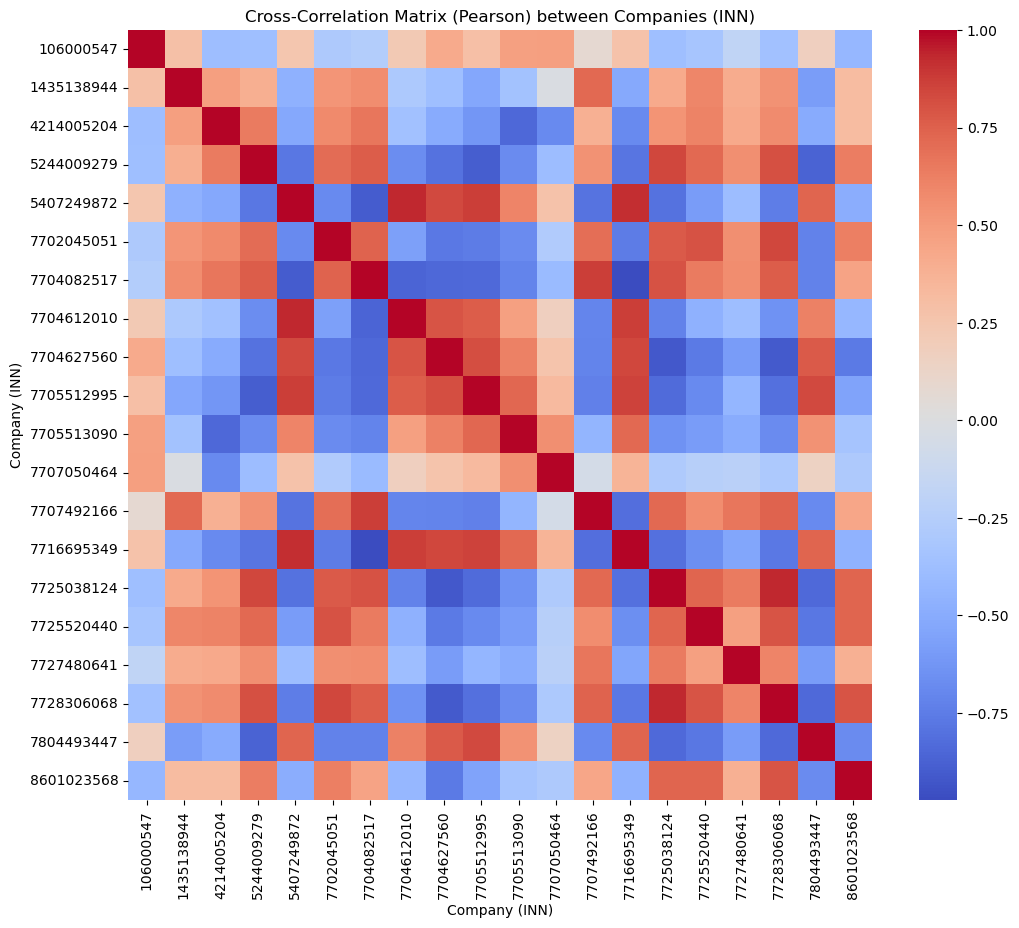

In [1174]:
nan_indices = cross_corr_matrix.isna().any(axis=1)  # Идентификаторы с NaN
valid_indices = cross_corr_matrix.index[~nan_indices]  # Только корректные идентификаторы

# Формируем симметричную матрицу
cross_corr_matrix = cross_corr_matrix.loc[valid_indices, valid_indices]


# === Шаг 5. Визуализация через тепловую карту ===
plt.figure(figsize=(12, 10))
sns.heatmap(cross_corr_matrix, cmap="coolwarm")
plt.title("Cross-Correlation Matrix (Pearson) between Companies (INN)")
plt.xlabel("Company (INN)")
plt.ylabel("Company (INN)")
plt.show()

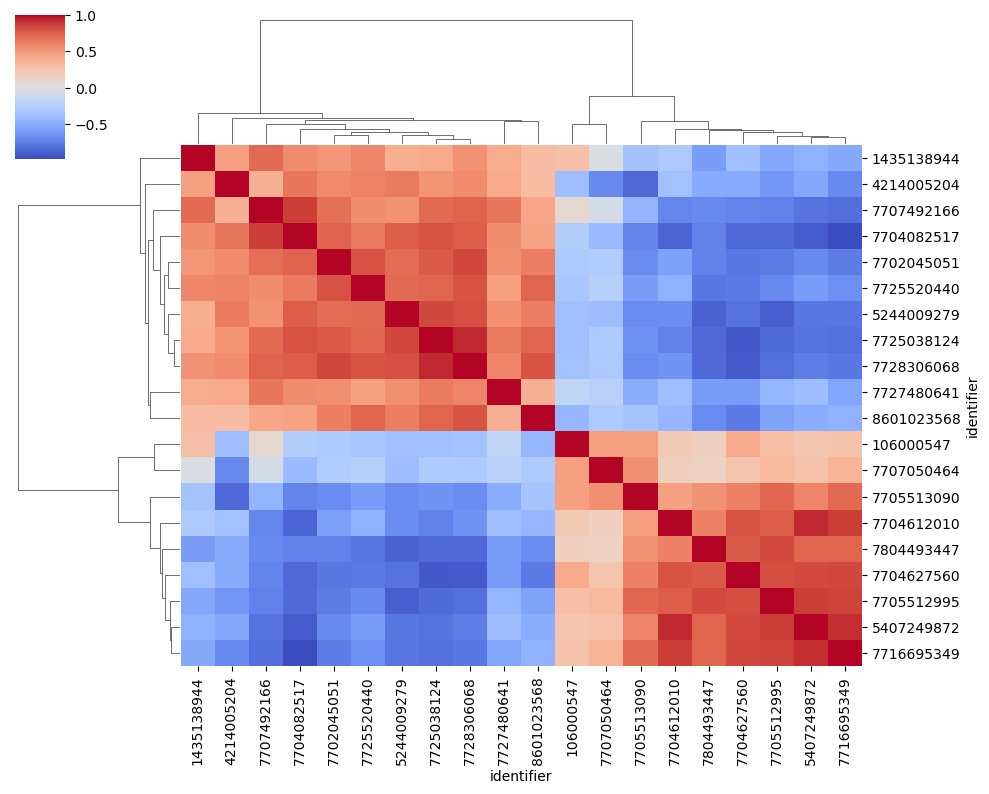

In [1176]:
sns.clustermap(cross_corr_matrix.fillna(0), cmap='coolwarm', figsize=(10, 8))
plt.show()

In [1178]:
len(cross_corr_matrix.columns), len(cross_corr_matrix.index)

(20, 20)

In [1180]:
U, S, Vt = np.linalg.svd(cross_corr_matrix)

In [1182]:
U, S, Vt

(array([[-1.01691867e-01, -5.41910738e-01, -2.64331440e-01,
         -1.34298590e-01,  1.09394337e-01, -7.97195218e-02,
          3.40176600e-01,  4.56983366e-01,  2.53526129e-01,
          3.95562010e-01, -1.39643092e-01, -3.30245304e-02,
          9.82811633e-03, -1.35017638e-01,  2.17198824e-02,
          6.35369566e-02,  8.92324973e-03,  6.42371780e-03,
          2.53051196e-02, -1.66177964e-02],
        [ 1.61575229e-01, -3.50115058e-01, -2.69204740e-01,
         -4.20831783e-01,  2.18506441e-01, -1.56578952e-01,
         -3.58694844e-02, -3.21708558e-01, -2.95824346e-01,
         -1.31466303e-01, -2.01946962e-02,  3.36903121e-01,
         -2.12947621e-02,  1.37840885e-01,  1.92920681e-02,
         -2.46194195e-01, -1.67123512e-01,  1.26171763e-01,
         -1.69368202e-01,  2.30255896e-01],
        [ 1.96733568e-01,  2.84643063e-01, -4.01154423e-01,
         -2.30921429e-01,  1.22842418e-01,  6.68040905e-02,
         -6.54758687e-03, -1.86111621e-01,  3.21069693e-02,
          2.

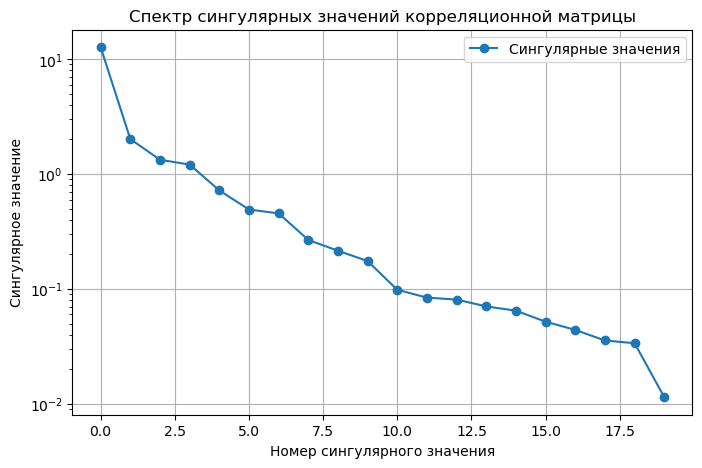

[0.63002157 0.73006177 0.79613492 0.85612977 0.89186859]


In [1184]:
# Строим спектр сингулярных значений
plt.figure(figsize=(8, 5))
plt.plot(S, marker="o", linestyle="-", label="Сингулярные значения")
plt.yscale("log")
plt.xlabel("Номер сингулярного значения")
plt.ylabel("Сингулярное значение")
plt.title("Спектр сингулярных значений корреляционной матрицы")
plt.legend()
plt.grid()
plt.show()

# Доля информации, объясняемая первыми 5 сингулярными значениями
explained_variance = np.cumsum(S) / np.sum(S)
print(explained_variance[:5])


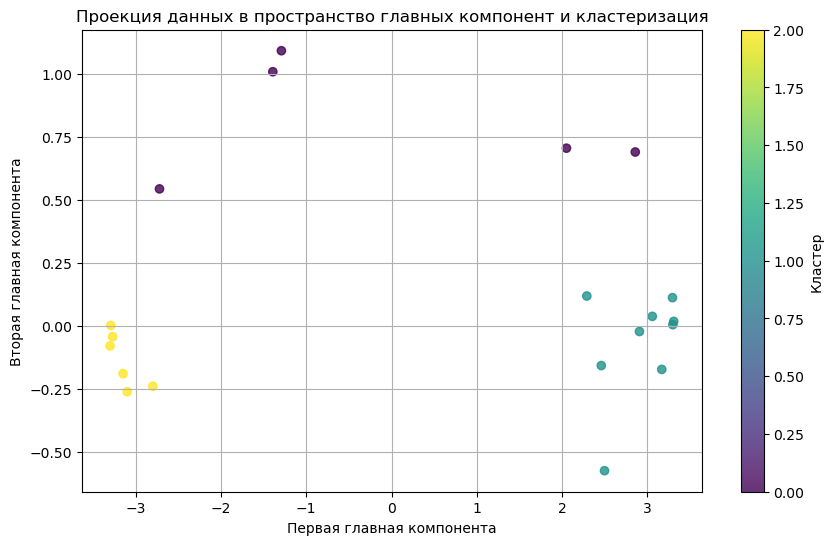

Топ-5 компаний по вкладу в главные компоненты: ['7705513090', '1435138944', '7707492166', '7707050464', '106000547']


In [1186]:
# Применяем SVD для выделения главных компонент
n_components = 2  # Берем две главные компоненты
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(cross_corr_matrix)

# Оцениваем, какие компании сильнее всего связаны с главными компонентами
components = svd.components_
importance = np.abs(components).sum(axis=0)
top_companies = cross_corr_matrix.columns[np.argsort(importance)[-5:]]  # Топ-5 компаний по вкладу

# Нормализация перед кластеризацией
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Кластеризация с помощью KMeans
n_clusters = 3  # Можно подобрать оптимальное число кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция данных в пространство главных компонент и кластеризация")
plt.colorbar(label="Кластер")
plt.grid()
plt.show()

# Выводим компании, которые сильнее всего связаны с главными компонентами
print("Топ-5 компаний по вкладу в главные компоненты:", list(top_companies))

In [1188]:
relevant_companies = list(cross_corr_matrix.index.intersection(pivot_df.columns))
# relevant_companies = list(map(int, cross_corr_matrix.index.intersection(pivot_df.columns)))
len(relevant_companies)

20

In [1190]:
relevant_companies

['106000547',
 '1435138944',
 '4214005204',
 '5244009279',
 '5407249872',
 '7702045051',
 '7704082517',
 '7704612010',
 '7704627560',
 '7705512995',
 '7705513090',
 '7707050464',
 '7707492166',
 '7716695349',
 '7725038124',
 '7725520440',
 '7727480641',
 '7728306068',
 '7804493447',
 '8601023568']

In [1192]:
pivot_df_hurst = pivot_df.loc[:, pivot_df.columns.intersection(relevant_companies)]
pivot_df_hurst

identifier,106000547,1435138944,4214005204,5244009279,5407249872,7702045051,7704082517,7704612010,7704627560,7705512995,7705513090,7707050464,7707492166,7716695349,7725038124,7725520440,7727480641,7728306068,7804493447,8601023568
resampled_dates,,,,,,,,,,,,,,,,,,,,
2015-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,4.0,3.0,3.0,2.0,7.0,2.0,1.0,4.0,5.0,7.0,5.0,2.0,1.0,5.0,1.0,1.0,4.0,2.0,7.0,2.0
2024-08-31,4.0,3.0,3.0,2.0,7.0,2.0,1.0,4.0,5.0,7.0,5.0,3.0,1.0,5.0,1.0,1.0,4.0,2.0,7.0,2.0
2024-09-30,4.0,3.0,3.0,2.0,7.0,2.0,1.0,4.0,5.0,7.0,5.0,3.0,1.0,5.0,1.0,1.0,4.0,2.0,7.0,2.0


In [1194]:
hurst_ = []  # Общий массив
for col in pivot_df_hurst.columns:  # Итерируемся по каждому столбцу (объекту)
    values = pivot_df_hurst[col].dropna().values  # Убираем NaN и берем значения
    
    if len(values) > 0:  # Проверяем, что массив не пустой
        values_centered = values - np.mean(values)  # Вычитаем среднее
        hurst_.append(values_centered)  # Добавляем в общий массив

# Проверим содержимое
print("Общий массив Hurst:", hurst_)


Общий массив Hurst: [array([-0.90425532, -0.90425532, -0.90425532, -0.90425532, -0.90425532,
       -0.90425532, -0.90425532, -0.90425532, -0.90425532, -0.90425532,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.09574468,  0.09574468,  0.09574468,
        0.09574468,  0.09574468,  0.0957446

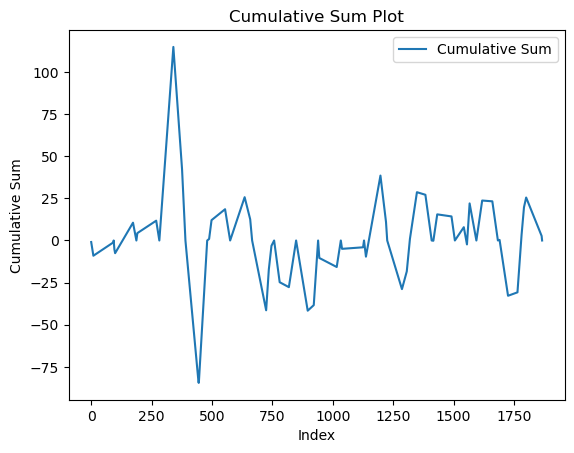

In [1196]:
# Объединяем массивы
hurst_flat = np.concatenate(hurst_)  
hurst_cumsum = np.cumsum(hurst_flat)  # Считаем накопленную сумму

# Построение графика
plt.plot(hurst_cumsum, label="Cumulative Sum")
plt.xlabel("Index")
plt.ylabel("Cumulative Sum")
plt.title("Cumulative Sum Plot")
plt.legend()
plt.show()

NameError: name 'N' is not defined

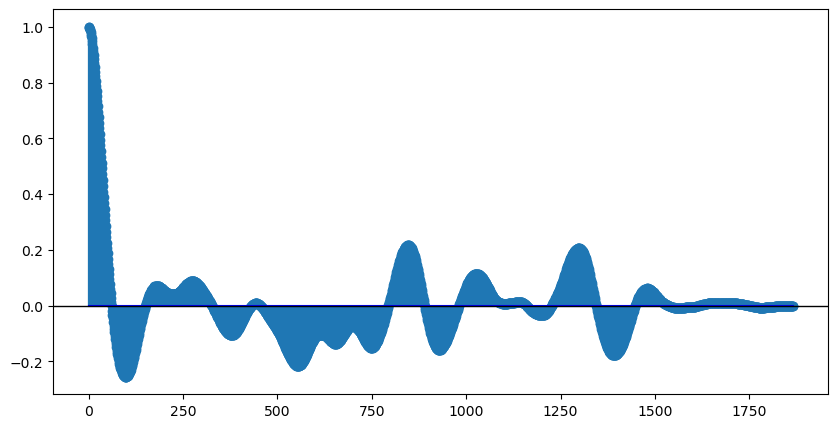

In [1198]:
Z = hurst_cumsum
lags = len(Z) - 1
# lags = 300
acf_values = acf(Z, nlags=lags, fft=True)
# N = len(acf_values)
# Визуализация
plt.figure(figsize=(10, 5))
plt.stem(range(lags + 1), acf_values, basefmt="b")  # basefmt="b" = синий маркер на оси
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=1.96/np.sqrt(N), linestyle='--', color='red', label="Граница значимости")
plt.axhline(y=-1.96/np.sqrt(N), linestyle='--', color='red')
plt.xlabel('Лаг')
plt.ylabel('АКФ')
plt.title('Автокорреляционная функция (АКФ)')
plt.legend()
plt.show()

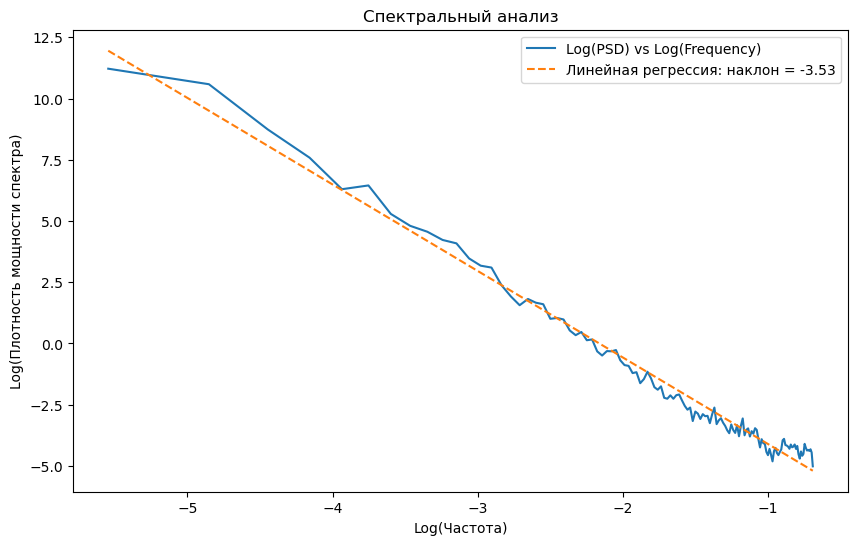

Наклон спектра: -3.53


In [1200]:
# Применяем FFT
frequencies, psd = signal.welch(Z, fs=1)  # fs=1, так как мы работаем с дискретным временным рядом

# Преобразуем PSD в логарифмическую шкалу
log_frequencies = np.log(frequencies[1:])  # Убираем нулевую частоту
log_psd = np.log(psd[1:])  # Убираем нулевое значение мощности

# Линейная регрессия для нахождения наклона
slope, intercept = np.polyfit(log_frequencies, log_psd, 1)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(log_frequencies, log_psd, label="Log(PSD) vs Log(Frequency)")
plt.plot(log_frequencies, slope * log_frequencies + intercept, '--', label=f'Линейная регрессия: наклон = {slope:.2f}')
plt.xlabel('Log(Частота)')
plt.ylabel('Log(Плотность мощности спектра)')
plt.title('Спектральный анализ')
plt.legend()
plt.show()

# Выводим наклон спектра
print(f"Наклон спектра: {slope:.2f}")


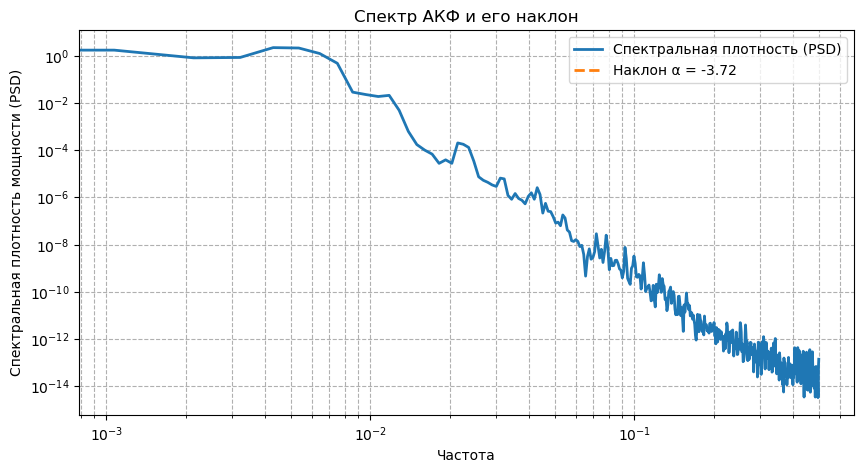

Найденный наклон спектра α ≈ -3.72


In [1202]:
from scipy.signal import welch
from scipy.optimize import curve_fit
# Данные АКФ
# lags = len(total_)
# acf_values = acf(total_, nlags=lags, fft=True)


# 1. Вычисляем спектральную плотность мощности (PSD)
frequencies, psd = welch(acf_values, fs=1.0, nperseg=len(acf_values)//2)

# 2. Функция для степенного закона: S(f) ~ f^(-alpha)
def power_law(f, a, alpha):
    return a * f ** (-alpha)

# 3. Фитируем наклон спектра в логарифмическом масштабе
valid = (frequencies > 0.01) & (frequencies < 0.5)  # Ограничим диапазон частот
popt, _ = curve_fit(power_law, frequencies[valid], psd[valid])

# 4. Визуализация спектра и аппроксимации
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, psd, label="Спектральная плотность (PSD)", linewidth=2)
plt.loglog(frequencies[valid], power_law(frequencies[valid], *popt), '--', 
           label=f"Наклон α = {popt[1]:.2f}", linewidth=2)

plt.xlabel("Частота")
plt.ylabel("Спектральная плотность мощности (PSD)")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.title("Спектр АКФ и его наклон")
plt.show()

print(f"Найденный наклон спектра α ≈ {popt[1]:.2f}")

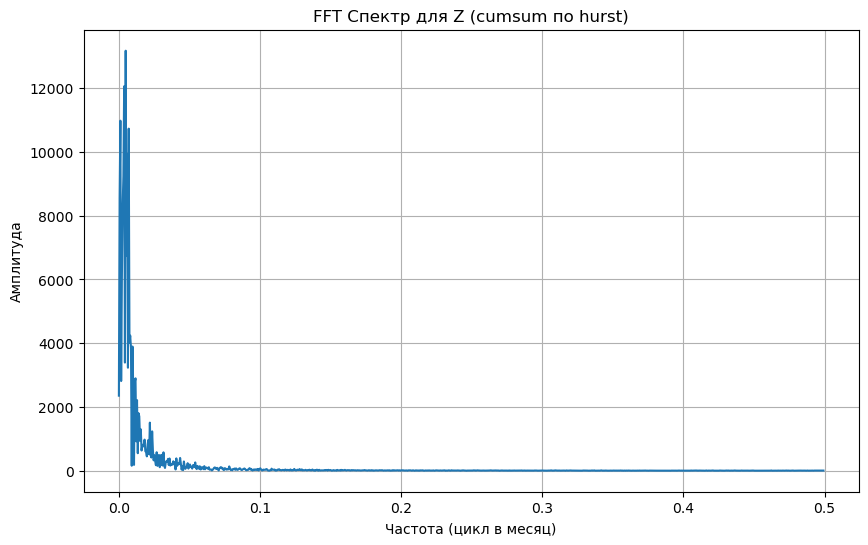

In [1204]:
# Пример массива Z (замените на ваш массив данных)
Z = hurst_cumsum  # ваш массив данных (например, cumsum по hurst)

# Применяем FFT
fft_values = np.fft.fft(Z)

# Получаем соответствующие частоты
frequencies = np.fft.fftfreq(len(Z), d=1)  # d=1, так как шаг 1 месяц

# Модуль FFT (амплитуда)
fft_magnitude = np.abs(fft_values)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], fft_magnitude[:len(frequencies)//2])  # Отображаем только положительные частоты
plt.xlabel('Частота (цикл в месяц)')
plt.ylabel('Амплитуда')
plt.title('FFT Спектр для Z (cumsum по hurst)')
plt.grid(True)
plt.show()

/var/folders/0w/pg719rr9519435t25t6yf2hm0000gn/T/ipykernel_13307/1779752598.py:13: RuntimeWarning: invalid value encountered in log
  log_frequencies = np.log(frequencies[1:])  # Убираем нулевую частоту


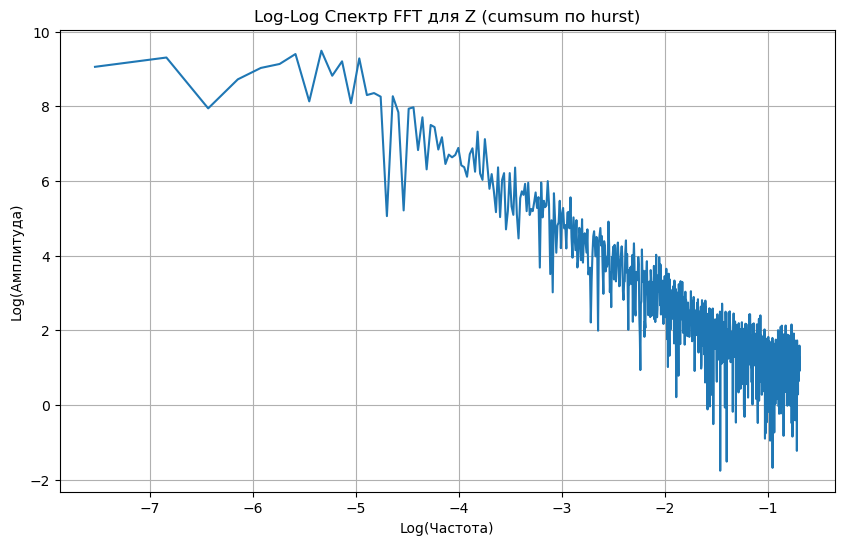

In [1205]:
Z = hurst_cumsum  # ваш массив данных (например, cumsum по hurst)

# Применяем FFT
fft_values = np.fft.fft(Z)

# Получаем соответствующие частоты
frequencies = np.fft.fftfreq(len(Z), d=1)  # d=1, так как шаг 1 месяц

# Модуль FFT (амплитуда)
fft_magnitude = np.abs(fft_values)

# Преобразуем в логарифмическую шкалу
log_frequencies = np.log(frequencies[1:])  # Убираем нулевую частоту
log_fft_magnitude = np.log(fft_magnitude[1:])  # Убираем нулевую амплитуду

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(log_frequencies, log_fft_magnitude)
plt.xlabel('Log(Частота)')
plt.ylabel('Log(Амплитуда)')
plt.title('Log-Log Спектр FFT для Z (cumsum по hurst)')
plt.grid(True)
plt.show()

In [1208]:
# Функция для вычисления R/S
def hurst_exponent(time_series):
    n = len(time_series)
    # Инициализация списков для R/S
    rs_values = []
    segment_lengths = []

    # Разбиваем временной ряд на сегменты
    for seg_len in range(10, n // 2, 10):  # Мы будем использовать сегменты длиной от 10 до n/2
        segments = [time_series[i:i+seg_len] for i in range(0, n, seg_len) if i+seg_len <= n]
        for segment in segments:
            # Среднее значение в сегменте
            mean_val = np.mean(segment)
            # Размах сегмента (максимум - минимум)
            R = np.max(segment) - np.min(segment)
            # Стандартное отклонение
            S = np.std(segment)
            if S != 0:
                rs_values.append(R / S)
                segment_lengths.append(seg_len)

    # Линейная регрессия для log(R/S) против log(длина сегмента)
    log_rs = np.log(rs_values)
    log_lengths = np.log(segment_lengths)

    # Линейная регрессия для нахождения наклона
    slope, intercept = np.polyfit(log_lengths, log_rs, 1)

    return slope  # Наклон — это и есть параметр Херста

# Пример использования для вашего массива Z (например, hurst_cumsum)
hurst_value = hurst_exponent(Z)

In [1172]:
hurst_value

0.09848718647102304